# Table of Content

* <a href='#Citation'>Citation</a>
* <a href='#Description'>Description</a>
* <a href='#Dataset'>Dataset</a>
* <a href='#imports'>Setup Imports and Variables<a/>
* <a href='#manipulation'>Data Manipulation</a>
* <a href='#eda'>Exploratory Data Analysis</a>
* <a href='#clustering'>KMeans Clustering</a>
* <a href='#ml'>ML for predicting movie ratings</a>
* <a href='#rs'>Recommendation Engine</a>
* <a href='#summary'>Analysis Summary</a>

![data_daycle](cycle.png)

# Citation

The description and dataset are taken from:

>F. Maxwell Harper and Joseph A. Konstan. 2015. The MovieLens Datasets: History and Context. ACM Transactions on Interactive Intelligent Systems (TiiS) 5, 4, Article 19 (December 2015), 19 pages. http://dx.doi.org/10.1145/2827872


# Description

This dataset **ml-latest-small** describes a 5-star rating and free-text tagging activity from **MovieLens**, a movie recommendation service. It contains **100004 ratings** and **1296 tags** across **9125 movies**. These data were created by **671 users** between **January 09, 1995 and October 16, 2016**. This dataset was generated on October 17, 2016.

The data are contained in the files **links.csv**, **movies.csv**, **ratings.csv** and **tags.csv** .

>**ratings.csv attributes:** userId, movieId, rating, timestamp

>**tags.csv attributes:** userId, movieId, tag, timestamp

>**movies.csv attributes:** movieId, title, genres

>**links.csv attributes:** movieId, imdbId, tmdbId


# Dataset

Now, lets take a sneak peak in our dataset files to see what it really looks like .

* Movies Table
![movies_df](movies.png)
* Ratings Table
![ratings_df](ratings.png)
* Links Table
![links_df](links.png)
* Tags Table
![tags_df](tags.png)

<a id='imports'></a>
# Setup Imports and Variables

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from wordcloud import WordCloud
from sklearn import model_selection
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn import metrics
from sklearn.linear_model import LogisticRegression

%matplotlib inline


links_df = pd.read_csv('links.csv',encoding="utf-8")
movies_df = pd.read_csv('movies.csv',encoding="utf-8")
tags_df = pd.read_csv('tags.csv',encoding="utf-8")
ratings_df = pd.read_csv('ratings.csv',encoding="utf-8")

<a id='manipulation'></a>
# Data Manipulation

 * Formating Date and Time from **timestamp** coloumn in tags Dataframe and Ratings Dataframe 
> Timestamps represent seconds since midnight Coordinated Universal Time (UTC) of January 1, 1970.

In [2]:
tags_df['timestamp'] = tags_df['timestamp'].apply(lambda x: datetime.utcfromtimestamp(x))
tags_df.head()

,userId,movieId,tag,timestamp
0,15,339,sandra 'boring' bullock,2006-01-29 12:29:30
1,15,1955,dentist,2007-10-26 21:44:21
2,15,7478,Cambodia,2007-02-04 03:49:57
3,15,32892,Russian,2007-02-04 21:59:26
4,15,34162,forgettable,2006-03-03 13:16:05


In [3]:
ratings_df['timestamp'] = ratings_df['timestamp'].apply(lambda x: datetime.utcfromtimestamp(x))
ratings_df.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,2009-12-14 02:52:24
1,1,1029,3.0,2009-12-14 02:52:59
2,1,1061,3.0,2009-12-14 02:53:02
3,1,1129,2.0,2009-12-14 02:53:05
4,1,1172,4.0,2009-12-14 02:53:25


* Extracting Movie's Release year from **title** coloumn. Title coloumn values has the format "movie_name (release_year)" .

In [4]:
movies_df['year'] = movies_df['title'].str.extract('.*\((.*)\).*', expand=True)
movies_df.title = movies_df.title.str[:-7]
movies_df.head()

,movieId,title,genres,year
0,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995
1,2,Jumanji,Adventure|Children|Fantasy,1995
2,3,Grumpier Old Men,Comedy|Romance,1995
3,4,Waiting to Exhale,Comedy|Drama|Romance,1995
4,5,Father of the Bride Part II,Comedy,1995


Some movie names does not contain release dates, lets identify them.

In [5]:
movies_df[movies_df['year'].isnull()]

,movieId,title,genres,year
9017,143410,Hye,(no genres listed),NaN
9063,151307,The Lovers and the,(no genres listed),NaN
9118,162376,Stranger,Drama,NaN
9124,164979,"Women of '69,",Documentary,NaN


**Genres** coloumn contains a pipe (|) seperated list of genres in each row, lets One-hot-encode them using panda's get_dummies() function. We will use this later in our notebook.

In [6]:
# One hot encoding movies genres properly.
genres_unique = pd.DataFrame(movies_df.genres.str.split('|').tolist()).stack().unique()
genres_unique = pd.DataFrame(genres_unique, columns=['genre'])
movies = movies_df.join(movies_df.genres.str.get_dummies().astype(bool))
movies.drop('genres', inplace=True, axis=1)
movies.head()

,movieId,title,year,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story,1995,False,False,True,True,True,True,False,...,False,False,False,False,False,False,False,False,False,False
1,2,Jumanji,1995,False,False,True,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
2,3,Grumpier Old Men,1995,False,False,False,False,False,True,False,...,False,False,False,False,False,True,False,False,False,False
3,4,Waiting to Exhale,1995,False,False,False,False,False,True,False,...,False,False,False,False,False,True,False,False,False,False
4,5,Father of the Bride Part II,1995,False,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False


Since movies Dataframe and links Dataframe contains 100% unique movieId, lets merge them together to form a single Dataframe.

In [7]:
movies_with_links =  movies_df.merge(links_df,on='movieId',how='inner')
movies_with_links.head()

,movieId,title,genres,year,imdbId,tmdbId
0,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995,114709,862.0
1,2,Jumanji,Adventure|Children|Fantasy,1995,113497,8844.0
2,3,Grumpier Old Men,Comedy|Romance,1995,113228,15602.0
3,4,Waiting to Exhale,Comedy|Drama|Romance,1995,114885,31357.0
4,5,Father of the Bride Part II,Comedy,1995,113041,11862.0


<a id='eda'></a>
# Exploratory Data Analysis (EDA)

Computing and ploting common Statistical measures of each of our Dataframe. Visit each hyperlink below. 

* <a href='movies.html'>Movies Statistical Measures</a>

* <a href='ratings.html'>Ratings Statistical Measures</a>

* <a href='tags.html'>Tags Statistical Measures</a>

* <a href='links.html'>Links Statistical Measures</a>


#### Code for generating these HTML Files
    import pandas_profiling

    movies_profile = pandas_profiling.ProfileReport(movies_df)
    ratings_profile = pandas_profiling.ProfileReport(ratings_df)
    tags_profile = pandas_profiling.ProfileReport(tags_df)
    links_profile = pandas_profiling.ProfileReport(links_df)

    movies_profile.to_file(outputfile="movies.html")
    ratings_profile.to_file(outputfile="ratings.html")
    tags_profile.to_file(outputfile="tags.html")
    links_profile.to_file(outputfile="links.html")

### Growth in movie production per year.
Now lets plot a line chart to analyze the growth of movies produced/released per year.

What we see here is almost an exponential growth in movie production but a drop by the end of 2015. Thats evident because the dataset contains only 65 movies released in 2016.

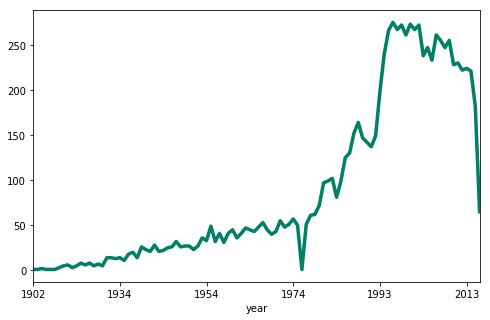

In [8]:
movies_with_year = movies_df.dropna()
movies_with_year = movies_with_year[movies_with_year.year != '2007-'] #eleminating a bad entry in years coloumn
movies_with_year.sort_values(by='year').groupby('year').size().plot(kind='line',lw='3.5',grid=False,colormap="summer", figsize=(8,5)) 

### Number of ratings given by each user

Now lets determine how many ratings were given by each user on average.

The histogram representation suggests that most of the users gave approx 1-500 ratings. Whats interesting here are the outliers; there are some users who gave approximately 2400 ratings. Which is insane! Just imagine how much time they spent watching those ~2400 movies ?? or maybe they rated without even whatching. who knows !

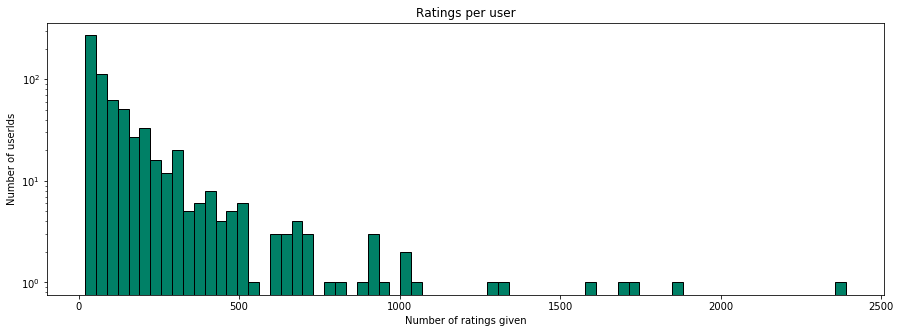

In [9]:
temp = ratings_df[['userId', 'movieId']].groupby('userId').count()
temp.columns=['rating_count']
plt.figure(figsize=(15,5))
temp.rating_count.plot(kind='hist',colormap='summer', bins=70, edgecolor='black', log=True)
plt.title('Ratings per user')
plt.xlabel('Number of ratings given')
plt.ylabel('Number of userIds')
plt.show()

### Top movies per year based on user ratings

Analyzing top rated movies by users per year should be quite interesting. Lets write a function to achieve this. Given the year and number of movies, the function plots a horizontal bar chart representing the sum of ratings given to each movie by users.

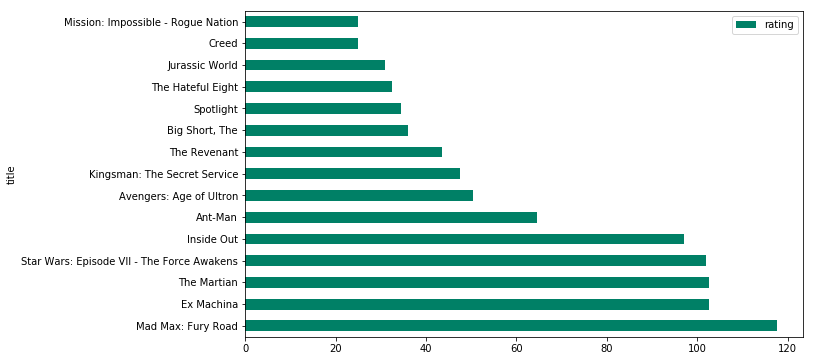

In [10]:
def topMoviesPerYear(year,num):
    ratings = ratings_df[ratings_df['userId'].isin(ratings_df['userId'].unique())]
    ratings = ratings.groupby('movieId', as_index=False)['rating'].sum()
    ratings = pd.merge(ratings, movies_df.dropna(), how='inner', on='movieId')
    ratings = ratings[ratings['year'].str.contains(year)]
    ratings = ratings.sort_values(by=['rating'], ascending=[False])[:num]
    ratings.plot(kind='barh', y='rating', x='title', figsize=(10,6),colormap="summer")

# Top 15 movies of year 2015
topMoviesPerYear('2015',15)

### Movies per genre 

Lets analyze, to which genre most of the movies present in our dataset belongs. Pie chart for such a a scenario seems a perfect fit.

Its very evident from the pie chart that most of the movies belong to genre "Drama" and its a clear winner. After "Drama", "Comedy" is the most popular genre. This suggests that most people prefer watching "Drama" and "Comedy" movies hence most movies produced belongs to these genres.

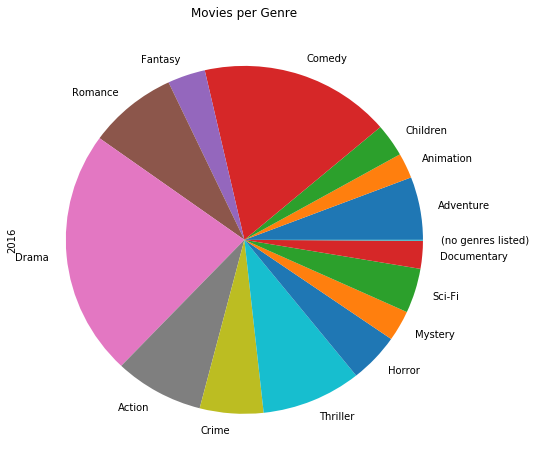

In [11]:
temp = movies[['movieId', 'year']].groupby('year')
df = pd.DataFrame()

for genre in genres_unique.genre:
    temp = movies[movies[genre]][['movieId', 'year']].groupby('year')
    df[genre]=temp.movieId.nunique().cumsum()
    
plt.figure(figsize=(8,8))

df.iloc[-1].plot(kind='pie', title="Movies per Genre")

### Movie's rating distribution by each genre and  by users

Most of the ratings given to movies (all genres) are around 4. This depicts a psychological behavior of users because most people dont bother rating movies which are not good enough. Distribution of "Horror" movies is somewhat notable here, it slightly varies from the distribution of other genres. There could be 2 possible reasons for that.

* Maybe people dont like getting scared hence they rate it differently
* Users expect alot and horror movies arent as scary as they expected hence they downrate it.

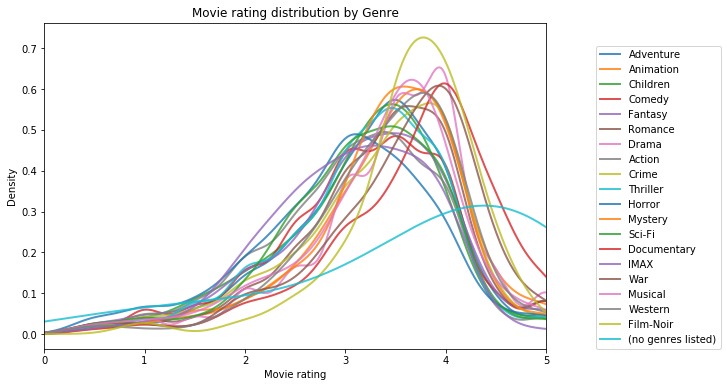

In [12]:
temp = ratings_df[['movieId','rating']].groupby('movieId').mean()

for genre in genres_unique.genre:
    temp = movies[movies[genre]==True]
    temp = ratings_df[ratings_df.set_index('movieId').index.isin(temp.set_index('movieId').index)]
    temp = temp[['movieId','rating']].groupby('movieId').mean()
    temp.rating.plot(grid=False,lw=2,alpha=0.8, kind='density', label=genre,figsize=(9,6))
    
plt.legend(loc=(1.1,0))
plt.xlim(0,5)
plt.xlabel('Movie rating')
plt.title('Movie rating distribution by Genre')
plt.show()

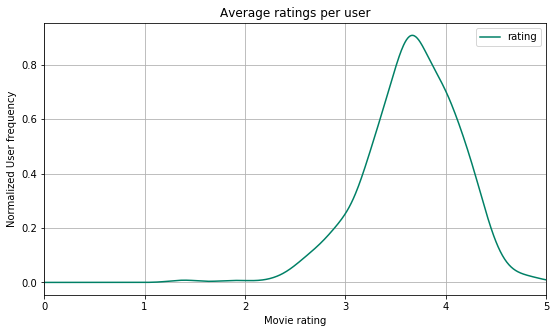

In [13]:
temp = ratings_df[['userId','rating']].groupby('userId').mean()
temp.plot(kind='kde', grid=True,colormap="summer", figsize=(9,5))

plt.xlim(0,5)
plt.xlabel ('Movie rating')
plt.ylabel ('Normalized User frequency')
plt.title ('Average ratings per user')
plt.show()

### Scatter plot of movies released and movie Ids

This plot gave us some new insights in our dataset:

* Most of the movies in movielens database with movie ids 25000+ are the ones which were released after year 2000.
* There is a wide range of movie ids before 25000 which are missing in this dataset.

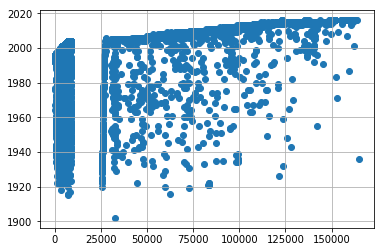

In [14]:
scatter = movies_df[['movieId','year']]
scatter = scatter.dropna()
scatter = scatter.drop([8507,8505]) 
scatter['year'] = scatter['year'].astype(int)
scatter.head()

plt.scatter(x=scatter.iloc[:, 0], y=scatter.iloc[:, 1])
plt.grid()
plt.show()

### Covariance between Number of Ratings and Movie's released year

This plot shows us the covariance among the number of ratings given by users to a movie which was released in a perticular year. For example according to this dataset, movies released in 1996 were rated the most number of times. As we know that this dataset was published in 2016, we can say that movies which are a decade old has the most number of ratings. Thats quite intuitive as well.


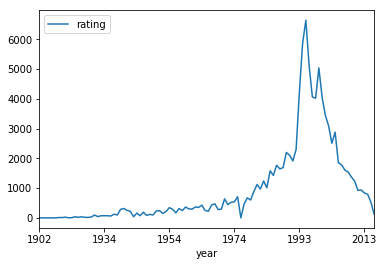

In [15]:
movies_df.rename(columns = {'movie_id':'movieId'}, inplace=True)
newdf = pd.merge(movies_df,ratings_df,on='movieId', how='inner')
ratings_per_year = newdf.groupby('year')['rating'].size()

# checking if this is done correctly, to do so, ill take the sum of all ratings
# which should be equal to num rows in ratings df.
newdf.groupby('year')['rating'].size().sum() # === 100000

ratings_per_year = pd.DataFrame(ratings_per_year)
ratings_per_year.reset_index(level=0,inplace=True)
ratings_per_year.drop(95,inplace=True) # droping bad year value 2007-
ratings_per_year.sort_values('year').plot(x='year')

### WordCloud of Tags given to each Genre.

This shows us the real power of wordclouds and why they are the best when visualizing textual data ! In our dataset we have a "Genre" column in Movies DataFrame and "Tags" column in Tags DataFrame. Given a Genre, this function draws a wordcloud of all the tags which were given to movies of that genre. I did this by initially getting the "Movie Ids" of all the movies which belong to user-entered genre then getting the all the tags against those ids from tags Dataframe.

For plotting the wordcloud, I used a wordcloud library which takes in a list of keywords and plots them. The bigger the word, the more its frequency is. which means the word which is the biggest in the cloud is the tag which was assigned to that genre most number of times.

In [16]:
def wordCloud(movie_genre):
    ids = movies_df[movies_df['genres'].str.contains(movie_genre)].movieId.tolist() #getting mov IDs of the entered genre
    text = tags_df[tags_df['movieId'].isin(ids)]['tag'].tolist() #getting tags which belong to those movie ids
    strtext = " ".join(str(x) for x in text)

    wordcloud = WordCloud(background_color='white',colormap='summer').generate(strtext)

    plt.figure(figsize=(8,8))
    plt.axis("off")
    plt.imshow(wordcloud,interpolation="bilinear")

Lets draw wordclouds of some famous Genres .

"Anime", "Pixar" and "Fantasy" are no doubt the most relevant tags for "Animation" Genre.

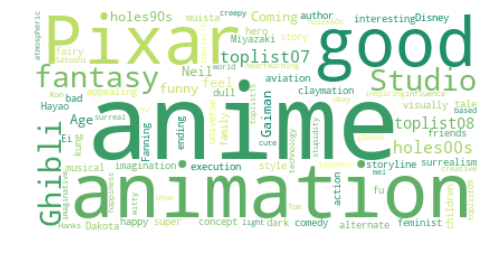

In [17]:
wordCloud("Animation")

Comedy tag in romance genre, thats interesting !

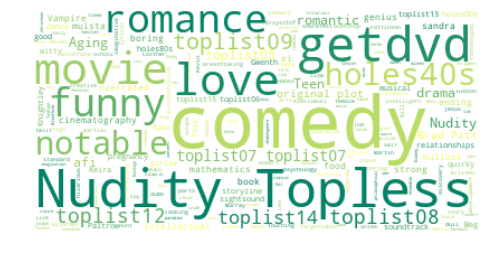

In [18]:
wordCloud("Romance")  

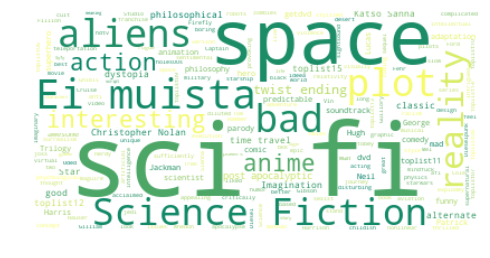

In [19]:
wordCloud("Sci-Fi")

<a id='clustering'></a>
# K-Means Clustering

Lets now check if K-means clustering algorithm can find some underlying relation among different movie genres. But one limition of kmeans is that the number of clusteres must be prespecified. So, we will use "Elbow method" to determine the optimal number of clusters.

Looking at the elbow plot below, 20 apears to be an optimal choice for the number of clusters.

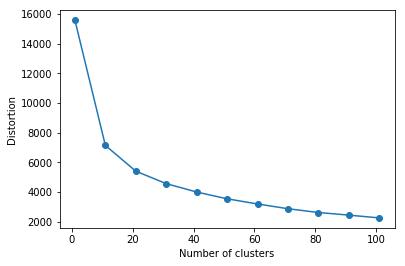

In [20]:
from sklearn.cluster import KMeans

KM_data = movies = movies_df.join(movies_df.genres.str.get_dummies().astype(int))

KM_data.drop(['title','year','genres'],axis=1,inplace=True)
KM_data.set_index('movieId',inplace=True)
KM_data.shape

distortions =[]
i=1
while i < 102:
    km = KMeans(n_clusters=i,n_init =10,max_iter =100,random_state=0)
    km.fit(KM_data)
    distortions.append(km.inertia_)
    
    i+=10
x=[1,11,21,31,41,51,61,71,81,91,101]
plt.plot(x,distortions,marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()

* Now initializizing KMeans with 20 clusters and fiting it on our movie genres and predicting the cluster for first row of our data.

In [21]:
km = KMeans(n_clusters=20,n_init =10,max_iter =100,random_state=0)
km.fit(KM_data)
km.predict([KM_data.values[0]])

array([8], dtype=int32)

<a id="ml"></a>
# ML for Predicting Movie Ratings

Various ML models can be used to predict or classify the target values (in our case - ratings) given the appropriate features and the data ofcourse. Given our movies dataset we will train a model to predict the rating of a movie when given the "movie released year" and "one hot encoded genres" of that movie. Unfortunately, both the features and the size of our dataset is not enough to achive a good prediction accuracy but lets give it a try ! 

### Data Preprocessing

Before we feed this data to our model for training we must tailor it accordingly. Following are some steps used for preprocessing:

* In our dataset many users have rated many movies. To get exactly one rating for each movie I grouped the dataframe by movie ids and calculated the mean of all the ratings given to that movie by different users.
* In movies datafram, "genre" column is pipe separated which causes two major problems. One being that our model wouldn't be able to identify the proper underlying meaning of the pipe separated genre values and second the genres are categorical values which is not the relevant input format for many ML models. To solve these both issues, we will **One Hot Encode** our genres column using panda's get_dummies method.
* We will then merge both our movies and ratings dataframes to form a single df using panda's merge method.
* We will drop irrelevant features from our dataframe like title and movie_id which wont help us in predicting the target class.
* Currently our target variable - ratings are in the range 0-5. To make this a binary classification problem we will encode ratings less than 3 with 0 (bad) and ratings greater than 3 as 1 (good).

Now our dataset is ready for training.

In [22]:
ml_ratings = ratings_df.sort_values(by='movieId').groupby('movieId',as_index=False)['rating'].mean() #mean rating
ml_movies = movies_df.join(movies_df.genres.str.get_dummies().astype(int)) #one hot encoding
ml_movies.drop(['genres','title'], inplace=True, axis=1)
ml_movies = pd.merge(ml_movies,ml_ratings,on='movieId',how='inner') #merging
ml_movies.dropna(inplace=True)
ml_movies.drop([8476,8478],inplace=True)
ml_movies['year'] = ml_movies['year'].apply(int)
#rating ranges
ml_movies['rating'] = np.where(ml_movies['rating'].between(0,3), 0, ml_movies['rating']) # 0-3 : 0 (bad)
ml_movies['rating'] = np.where(ml_movies['rating'].between(3,5), 1, ml_movies['rating']) # 3-5 : 1 (good)
ml_movies['rating'] = ml_movies['rating'].apply(int)

ml_movies.drop('movieId',axis=1,inplace=True)
bad, good = ml_movies.groupby('rating').size()
print("As per our scaling, we now have {0} bad and {1} good rated movies".format(bad,good))

ml_movies.head()

As per our scaling, we now have 3278 bad and 5783 good rated movies


,year,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,...,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,rating
0,1995,0,0,1,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,1995,0,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,1995,0,0,0,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,1
3,1995,0,0,0,0,0,1,0,0,1,...,0,0,0,0,1,0,0,0,0,0
4,1995,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1


### Partitioning into Training Set and Test Set

Before training we need to reserve some data for later evaluating our model's accuracy and results.For that we will partition our data into 2 sets, one for training (80%) and other for validation (20%). We do so by using sklearn's train_test_split method.

We also have to seprate our target variable / class labels (ratings column) and use them for training as its a supervised learning problem.

In [23]:
# Extracting Features from dataset 
X = ml_movies.iloc[:,:21]
X = X.as_matrix() 

# Extracting labels column from dataset
Y = ml_movies[['rating']]
Y =Y.as_matrix().flatten()

from sklearn import model_selection
X_train, X_validation, Y_train, Y_validation = model_selection.train_test_split(X, Y, test_size=0.2, random_state=10)

print('\nLenth of Trainging set:\n',len(X_train),"\n")
print('Lenth of Test set:\n',len(X_validation))


Lenth of Trainging set:
 7248 

Lenth of Test set:
 1813


### Logistic Regression

Lets first train our dataset on logistic regression model and evaluate it using various metrics present as helper functions in scikit learn.

In [24]:
LR = LogisticRegression()
LR.fit(X_train, Y_train)
predictions = LR.predict(X_validation)

print('Accuracy:',accuracy_score(Y_validation, predictions)*100,"%\n")
print('Confusion Matrix:\n',confusion_matrix(Y_validation, predictions),"\n")
print('Classification Report:\n',classification_report(Y_validation, predictions),"\n")

Accuracy: 65.195808053 %

Confusion Matrix:
 [[ 114  555]
 [  76 1068]] 

Classification Report:
              precision    recall  f1-score   support

          0       0.60      0.17      0.27       669
          1       0.66      0.93      0.77      1144

avg / total       0.64      0.65      0.59      1813
 



65% accuracy is not bad at all given the size of data and the number of features. 

Since we are dealing with binary classification problem, plotting **ROC** and **PR** is very convienient. 

0.551985010505


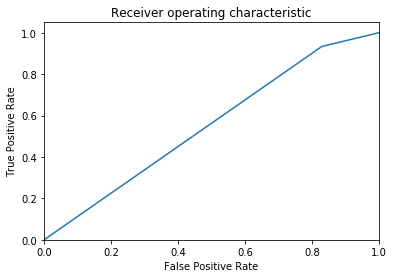

In [25]:
# ROC
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(2):
    fpr[i], tpr[i], _ = metrics.roc_curve(Y_validation, predictions)
    roc_auc[i] = metrics.auc(fpr[i], tpr[i])

print(metrics.roc_auc_score(Y_validation, predictions))
plt.figure()
plt.plot(fpr[1], tpr[1])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.show()

Text(0.5,1,'2-class Precision-Recall curve: AP=0.66')

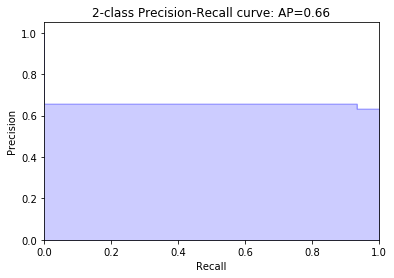

In [26]:
#PR
precision, recall, _ = metrics.precision_recall_curve(Y_validation,predictions)
average_precision = metrics.average_precision_score(Y_validation,predictions)

plt.step(recall, precision, color='b', alpha=0.2,where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2,color='b')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(average_precision))

### Support Vector Machines

After Logistic regressing lets try Support Vector Classifer and see how well it learns and predicts the movie ratings

In [27]:
from sklearn.svm import SVC
SVC = SVC()
SVC.fit(X_train, Y_train)
predictions = SVC.predict(X_validation)

print('Accuracy:',accuracy_score(Y_validation, predictions)*100,"\n")
print('Confusion Matrix:\n',confusion_matrix(Y_validation, predictions),"\n")
print('Classification Report:\n',classification_report(Y_validation, predictions),"\n")

Accuracy: 66.7953667954 

Confusion Matrix:
 [[ 173  496]
 [ 106 1038]] 

Classification Report:
              precision    recall  f1-score   support

          0       0.62      0.26      0.36       669
          1       0.68      0.91      0.78      1144

avg / total       0.66      0.67      0.62      1813
 



0.582968787565


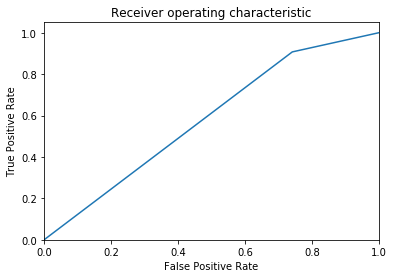

In [28]:
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(2):
    fpr[i], tpr[i], _ = metrics.roc_curve(Y_validation, predictions)
    roc_auc[i] = metrics.auc(fpr[i], tpr[i])

print(metrics.roc_auc_score(Y_validation, predictions))
plt.figure()
plt.plot(fpr[1], tpr[1])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.show()

Text(0.5,1,'2-class Precision-Recall curve: AP=0.67')

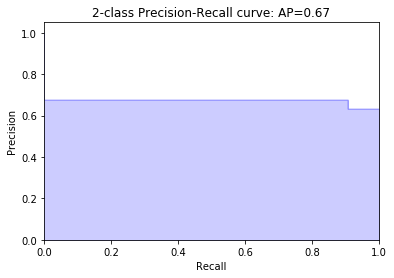

In [29]:
#PR
precision, recall, _ = metrics.precision_recall_curve(Y_validation,predictions)
average_precision = metrics.average_precision_score(Y_validation,predictions)

plt.step(recall, precision, color='b', alpha=0.2,where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2,color='b')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(average_precision))

<a id="rs"></a>
# Recommendation Engine

Since its a movies dataset, we can build a small recommendation engine which would suggest users movies based on ratings of other similar users - **Collaborative Filtering**. The working of this recommendation engine is simple. Initially we build a pivot table with movie ids as our indices, one column for each user and cell values as rating given to that movie by a user. If no rating is given, we set it to 0. Then we compute the cosine distances between the cell values to get the similarity values. Then given the name of a movie, recommendation suggests 5 movies based on that choice.

In [30]:
ratings_matrix = ratings_df.pivot_table(index=['movieId'],columns=['userId'],values='rating').reset_index(drop=True)
ratings_matrix.fillna( 0, inplace = True )
ratings_matrix.head()

from sklearn.metrics import pairwise_distances
from scipy.spatial.distance import cosine, correlation

movie_similarity = 1 - pairwise_distances( ratings_matrix.as_matrix(), metric="cosine" )
np.fill_diagonal(movie_similarity, 0 ) #Filling diagonals with 0s 
ratings_matrix = pd.DataFrame( movie_similarity )
ratings_matrix.head(5)

try:
    user_inp="Toy Story"
    inp=movies_df[movies_df['title']==user_inp].index.tolist()
    inp=inp[0]

    movies_df['similarity'] = ratings_matrix.iloc[inp]
    movies_df.columns = ['movie_id', 'title', 'genre','year','similarity']
    movies_df.head(2)
    
except:
    print("Sorry, the movie is not in the database!")

print("Recommended movies based on your choice of",user_inp ,": \n")
movies_df.sort_values( ["similarity"], ascending = False ).head()

Recommended movies based on your choice of  Toy Story : 



,movie_id,title,genre,year,similarity
2506,3114,Toy Story 2,Adventure|Animation|Children|Comedy|Fantasy,1999,0.594710
232,260,Star Wars: Episode IV - A New Hope,Action|Adventure|Sci-Fi,1977,0.576188
321,356,Forrest Gump,Comedy|Drama|Romance|War,1994,0.564534
644,780,Independence Day (a.k.a. ID4),Action|Adventure|Sci-Fi|Thriller,1996,0.562946
1019,1265,Groundhog Day,Comedy|Fantasy|Romance,1993,0.548023
